In [1]:
import pickle
import emcee
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import getdist
import corner

In [2]:
file = open('F_ann_val.pckl', 'rb')
F_val = pickle.load(file)
file.close()

Edges = np.array([5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
 5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
 3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
 1.00000000e+06])

E = np.exp(0.5*(np.log(Edges[1:])+np.log(Edges[:-1])))

cfac = 1.81493167e39

F_ann = cfac*F_val[0]
F_comb = cfac*F_val[1]
cov_F = cfac**2*F_val[2]
cov_Fcomb = cfac**2*F_val[3]

inv_covF = np.linalg.inv(cov_F)
inv_covFcomb = np.linalg.inv(cov_Fcomb)

F = np.zeros((7,12))
F[0:6] = F_ann[0:6]
F[6] = F_comb

cinvF = np.zeros((7,12,12))
cinvF[0:6] = inv_covF[0:6]
cinvF[6] = inv_covFcomb

covFs = np.zeros((7,12,12))
covFs[0:6] = cov_F[0:6]
covFs[6] = cov_Fcomb

#print(cinvF[0],inv_covF[0])
#print(F[2],F_ann[2])

#print(F[6])
#print(F_comb)
#print(inv_covF.shape)

print(cov_Fcomb.shape)


(12, 12)


In [3]:
## defining functions for F


def power(E,a,F0):
    E0 = 2e4
    return 1e-30*F0*(E/E0)**a

def chi2(theta,E,F_ann,cinv):
    a, F0 = theta
    x = F_ann - power(E,a,F0)
    return -0.5*np.dot(x, np.dot(cinv, x))


def log_prior(theta):
    if (-3 < theta[0] < -1) & (0.001 < theta[1] < 3):
        return 0.0
    return -np.inf

def log_prob(theta,E,F_ann,cinv):
    lprior = log_prior(theta)
    if not np.isfinite(lprior):
        return -np.inf
    return lprior + chi2(theta,E,F_ann,cinv)



In [4]:
nwalkers = 30
ndim = 2
niter = 5000
burn = 300

p0 = [[-2,0.3] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

mcsamples = np.zeros((7,ndim,nwalkers,niter-burn))
flat_samples = np.zeros((7,ndim,nwalkers*(niter-burn)))
for i in range(7):
    sampler = emcee.EnsembleSampler(nwalkers,ndim, lambda theta: log_prob(theta,E,F[i],cinvF[i]))
    pos,prob,state = sampler.run_mcmc(p0, niter, progress = True)
    mcsamples[i] = sampler.get_chain(discard = burn).T
    flat_samples[i] = sampler.get_chain(flat = True, discard = burn).T

100%|██████████| 5000/5000 [00:08<00:00, 604.57it/s]


0.19553162955779485 -2.122572851056821
0.26363403152468645 -2.04476599888092
0.35374806735035536 -2.0317041005943746
0.3181668068736109 -2.1301300517128343
0.35782437397751415 -2.045930874611917
0.4064589625310162 -2.2690069582231684
0.3303010888288107 -2.0734661102937277


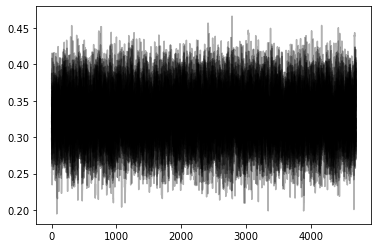

In [5]:
for i in range(7):
    print(np.mean(flat_samples[i,1,:]), np.mean(mcsamples[i,0,:]))

fig, axs = plt.subplots()
plt.plot(mcsamples[6,1,:,:].T,'k', alpha = 0.3)

Text(0, 0.5, 'F0')

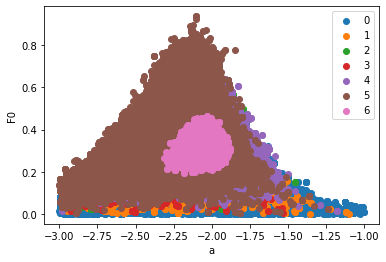

In [6]:
for i in range(7):
    plt.scatter(flat_samples[i,0,:].T,flat_samples[i,1,:].T, marker = 'o' ,label = f'{i}')
plt.legend()
plt.xlabel('a')
plt.ylabel('F0')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


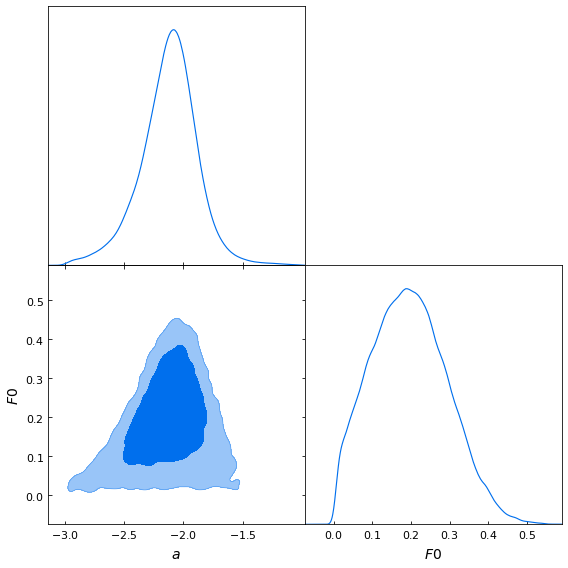

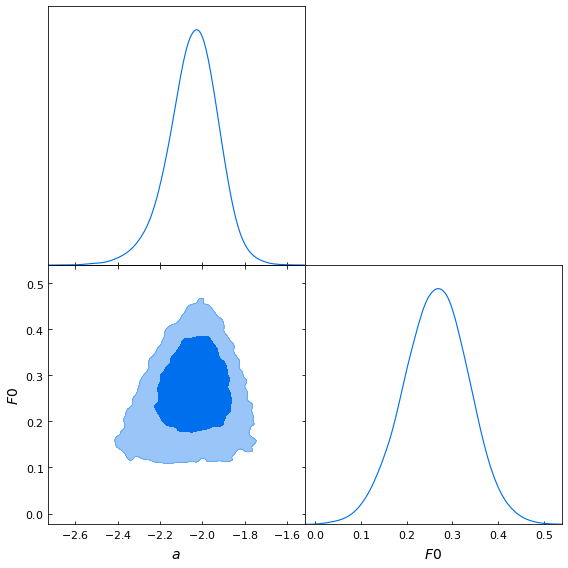

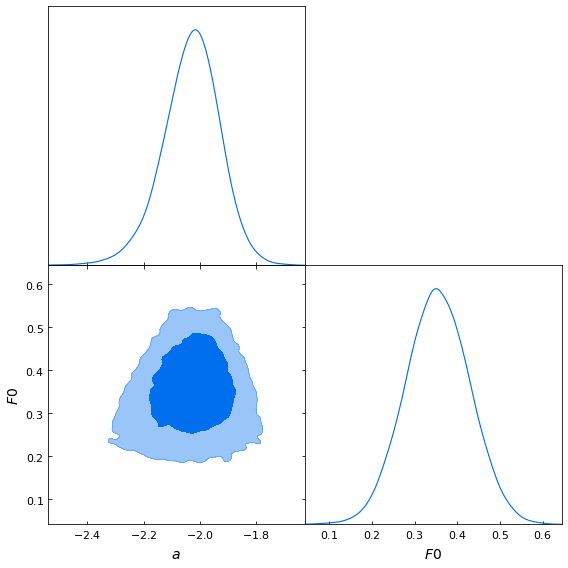

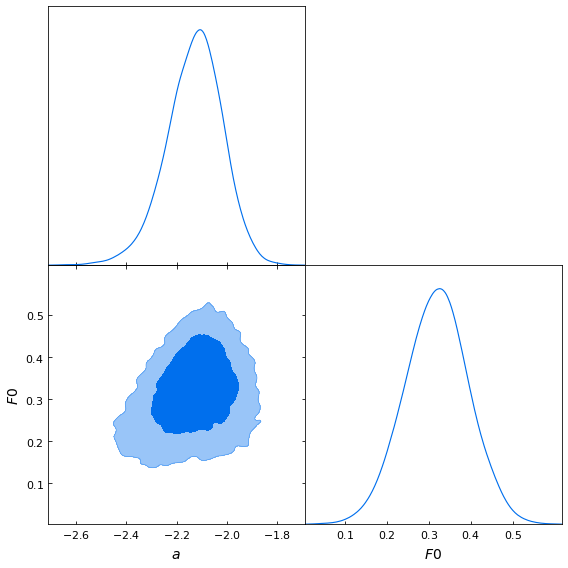

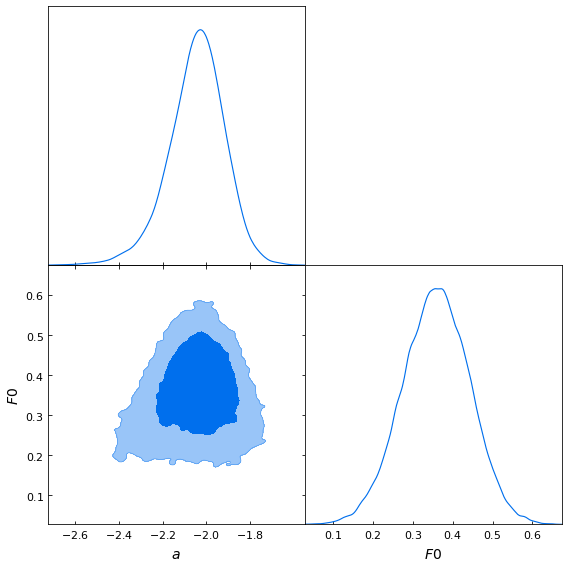

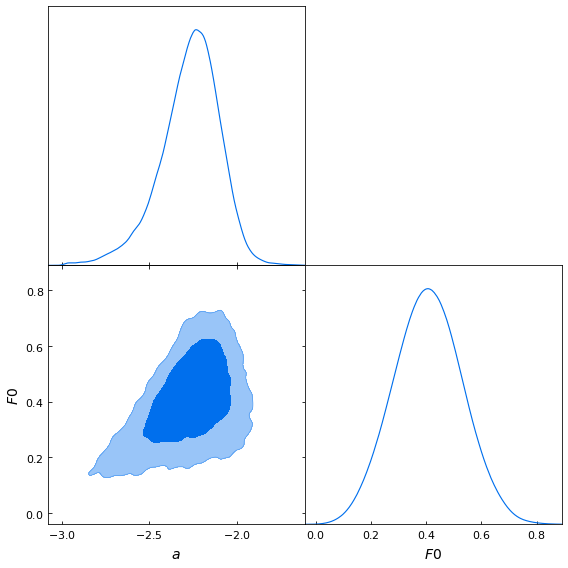

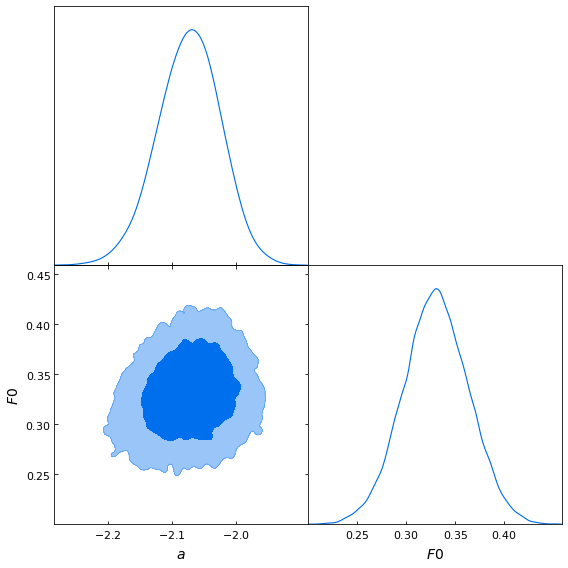

In [16]:
names = ['power index', 'constant']
labels =  ['a', 'F0']
for i in range(7):
    samples = MCSamples(samples= flat_samples[i].T ,names = names, labels = labels)
    g = plots.get_subplot_plotter(subplot_size = 4)
    g.triangle_plot([samples],filled = True)
    


1.9982955823369548
Removed no burn in
3.6486423892670774
Removed no burn in
4.66043517452507
Removed no burn in
4.097508270229287
Removed no burn in
4.263257641439571
Removed no burn in
3.267615122851486
Removed no burn in
9.831073428840226
Removed no burn in


<Figure size 576x576 with 0 Axes>

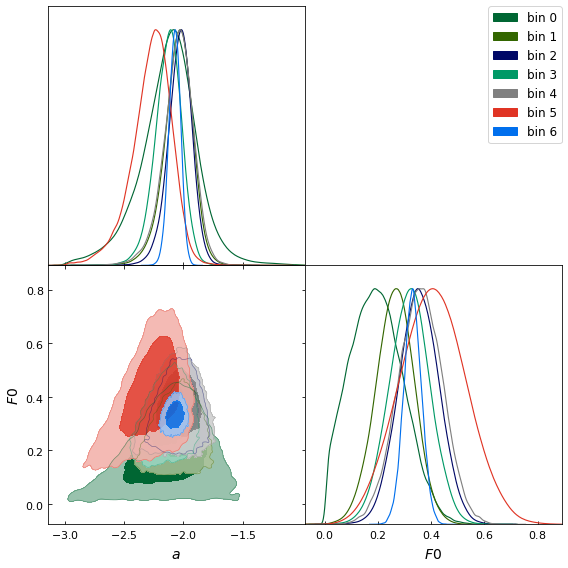

In [17]:
s = []
g = plots.get_single_plotter(ratio = 1, width_inch = 8 )
for i in range(7):
    print(np.mean(flat_samples[i, 1])/np.std(flat_samples[i, 1]))
    samples = MCSamples(samples = flat_samples[i].T, names = names , labels = labels, label = f'bin {i}')
    s.append(samples)
g.triangle_plot(s, filled=True)


In [8]:
def get_constraints(samples):
    for i, mean in enumerate(samples.getMeans()):
        print(samples.parLabel(i))
        upper = samples.confidence(i, upper=True, limfrac=0.05)
        print('upper = %.15f' % upper)
        lower = samples.confidence(i, upper=False, limfrac=0.05)
        print('lower = %.15f' % lower)
        print('mean = %.15f' %mean)
    return 


for i in range(7):
    samples = MCSamples(samples= flat_samples[i].T ,names = names, labels = labels)
    get_constraints(samples)



Removed no burn in
a
upper = -1.753053127557294
lower = -2.551813700986846
mean = -2.122572851056820
F0
upper = 0.362522307545613
lower = 0.040880881030132
mean = 0.195531629557794
Removed no burn in
a
upper = -1.856808081022793
lower = -2.259462642439993
mean = -2.044765998880929
F0
upper = 0.380234801204635
lower = 0.142214865412851
mean = 0.263634031524685
Removed no burn in
a
upper = -1.871490775643295
lower = -2.209649544618258
mean = -2.031704100594379
F0
upper = 0.478203227779257
lower = 0.229038812977355
mean = 0.353748067350357
Removed no burn in
a
upper = -1.952604870083893
lower = -2.327197648144945
mean = -2.130130051712831
F0
upper = 0.445643004125756
lower = 0.189419282882938
mean = 0.318166806873611
Removed no burn in
a
upper = -1.846933296038375
lower = -2.273833526557080
mean = -2.045930874611910
F0
upper = 0.493849847453622
lower = 0.218078780060240
mean = 0.357824373977517
Removed no burn in
a
upper = -2.020467470566217
lower = -2.579392879325668
mean = -2.2690069582

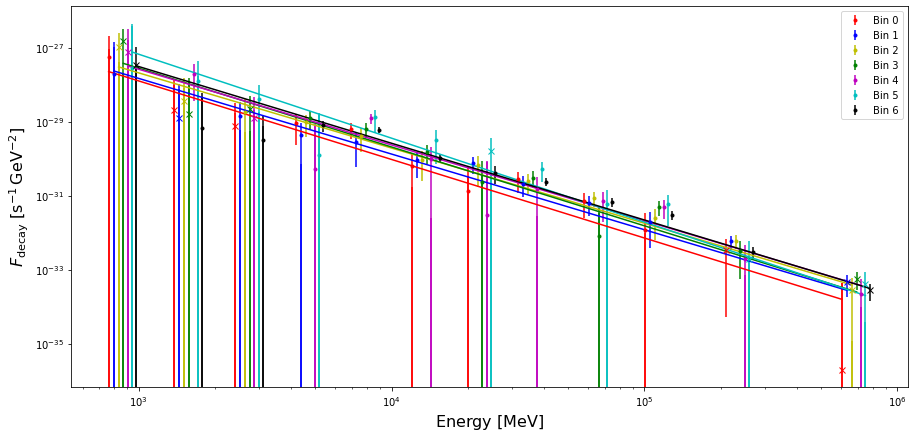

In [11]:
f = plt.figure()
for g, c in enumerate(['r', 'b', 'y', 'g', 'm', 'c','k']):
    plt.errorbar(E*(1+0.05*(g+1)), F[g], yerr= np.sqrt(np.diag(covFs[g])), fmt=c +'.', label=f'Bin {g}')
    plt.errorbar(E*(1+0.05*(g+1)), -F[g], yerr= np.sqrt(np.diag(covFs[g])), fmt=c +'x')
    plt.plot(E*(1+0.05*(g+1)), power(E,np.mean(flat_samples[g,0,:]),np.mean(flat_samples[g,1,:])),c)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$F_{\rm decay}\,\,[{\rm s}^{-1}\,{\rm GeV}^{-2}]$', fontsize = 16)
plt.xlabel('Energy'+ ' '+ r'$[{\rm MeV}]$', fontsize = 16)
plt.legend()
    
f.set_figwidth(15)
f.set_figheight(7)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


Text(0, 0.5, '$F_{\\rm ann}\\,\\,[{\\rm m}^{3}\\,{\\rm s}^{-1}\\,{\\rm GeV}^{-3}]$')

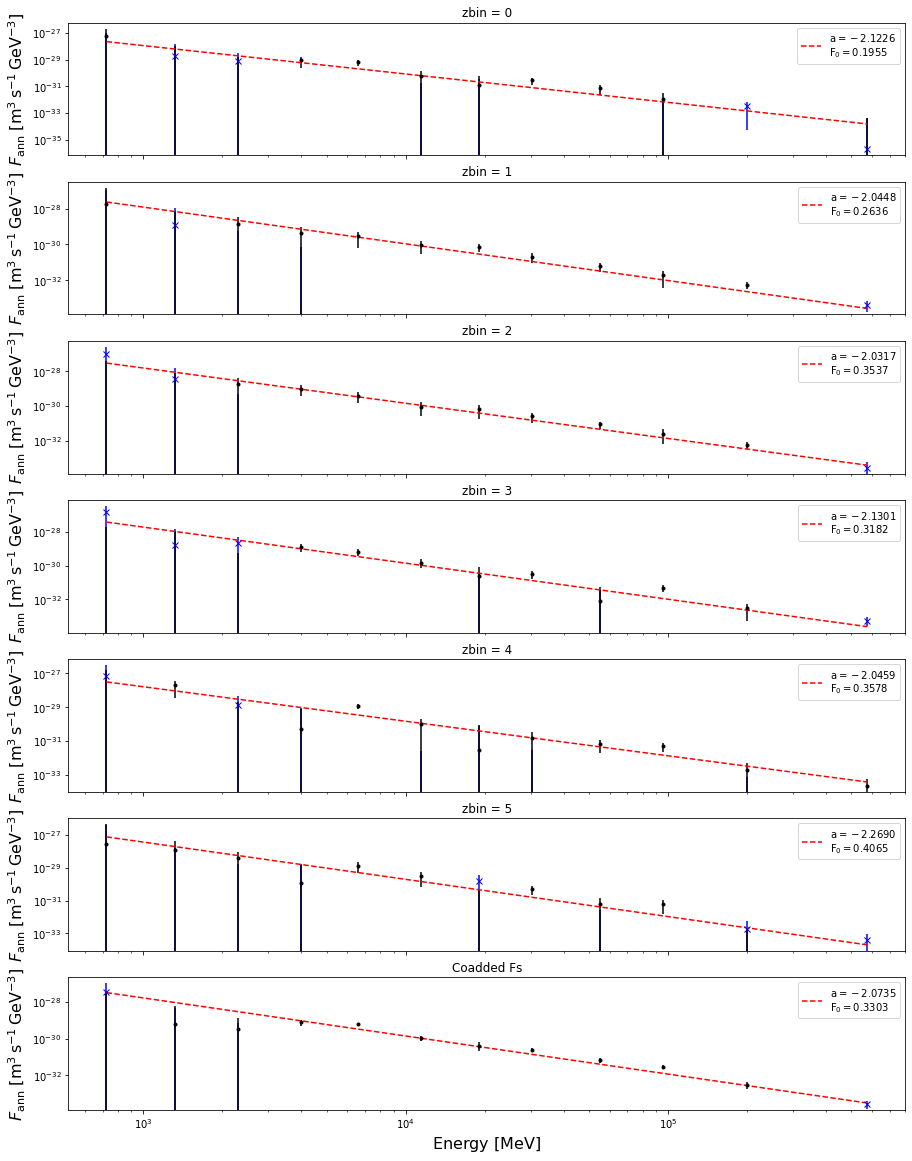

In [12]:
fig, axs = plt.subplots(7, figsize = (15,20), sharex = True)

for i in range(6):
    samples = MCSamples(samples= flat_samples[i].T ,names = names, labels = labels)
    textstr = '\n'.join((
    r'$\mathrm{a} =%.4f$' % (samples.getMeans()[0] , ),
    r'$\mathrm{F}_{0}=%.4f$' % (samples.getMeans()[1], )))
    ax = axs[i]
    ax.errorbar(E,-F[i], yerr = np.sqrt(np.diag(covFs[i])), fmt = 'bx')
    ax.errorbar(E,F[i],yerr = np.sqrt(np.diag(covFs[i])),fmt = 'k.')
    ax.plot(E,power(E,np.mean(flat_samples[i,0,:]),np.mean(flat_samples[i,1,:])), 'r--', label = f'{textstr}')
    ax.set_title(f'zbin = {i}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r'$F_{\rm ann}\,\,[{\rm m}^{3}\,{\rm s}^{-1}\,{\rm GeV}^{-3}]$', fontsize=16)
    ax.legend()
axs[-1].set_xlabel('Energy'+ ' '+ r'$[{\rm MeV}]$', fontsize = 16)
axs[6].errorbar(E,-F[6], yerr = np.sqrt(np.diag(covFs[6])), fmt = 'bx')
axs[6].errorbar(E,F[6],yerr = np.sqrt(np.diag(covFs[6])),fmt = 'k.')

sample6 = MCSamples(samples= flat_samples[6].T ,names = names, labels = labels)
textstr6 = '\n'.join((
    r'$\mathrm{a} =%.4f$' % (sample6.getMeans()[0] , ),
    r'$\mathrm{F}_{0}=%.4f$' % (sample6.getMeans()[1], )))

axs[6].plot(E,power(E,np.mean(flat_samples[6,0,:]),np.mean(flat_samples[6,1,:])), 'r--', label = f'{textstr6}')
axs[6].legend()
axs[6].set_title('Coadded Fs')
axs[6].set_xscale('log')
axs[6].set_yscale('log')
axs[6].set_ylabel(r'$F_{\rm ann}\,\,[{\rm m}^{3}\,{\rm s}^{-1}\,{\rm GeV}^{-3}]$', fontsize=16)